In [58]:
import os

def rename_files(directory):
    # Get list of files in the directory
    files = os.listdir(directory)
    # Sort the files
    files.sort()
    
    # Counter for renaming
    count = 1
    # Iterate over files
    for file_name in files:
        # Get the current file path
        old_path = os.path.join(directory, file_name)
        # Form the new file name with extension
        new_name = str(count) + os.path.splitext(file_name)[1]
        # Construct the new file path
        new_path = os.path.join(directory, new_name)
        # Rename the file
        os.rename(old_path, new_path)
        # Increment the counter
        count += 1

# Example usage
directory_path = 'C:/Users/Mr. Oliver/Desktop\CNN/FinalModels/DeepLabV3 Binary/dataset/test/images'
rename_files(directory_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/Mr. Oliver/Desktop\\CNN/FinalModels/DeepLabV3 Binary/dataset/test/images\\10.jpg' -> 'C:/Users/Mr. Oliver/Desktop\\CNN/FinalModels/DeepLabV3 Binary/dataset/test/images\\2.jpg'

In [65]:
import cv2
import numpy as np

def binarify(directory):
    files = os.listdir(directory)
    files.sort()

    for file in files:
        path = os.path.join(directory, file)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Define the specific pixel value you want to find
        specific_value = [1,2,3,4]  # Change this to your desired pixel value
        toClass = [1,1,0,0]

        for n, cl in enumerate(specific_value):
            # Find all pixels with the specific value
            indices = np.where(image == cl)

            # Extract the coordinates of the pixels with the specific value
            coordinates = list(zip(indices[0], indices[1]))

            for c in coordinates:
                image[c[0], c[1]] = toClass[n]
            
            cv2.imwrite(path, image)
        if 2 in image or 3 in image or 4 in image:
            print("FLAG")
        

    

directory_path = 'C:/Users/Mr. Oliver/Desktop\CNN/FinalModels/DeepLabV3 Binary/dataset/train/labels_1D'
binarify(directory_path)

In [1]:
#https://heartbeat.comet.ml/image-segmentation-with-transfer-learning-pytorch-5ada7121c6ab
import os
import pickle
import matplotlib.pyplot as plt
import time

from imutils import paths
from files.dataset import SegmentationDataset, EarlyStopper
from files import config

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex, Dice
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.classification import JaccardIndex, MulticlassAccuracy
from torch import nn

file_path = "C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3 Binary"

def binarifyModel(model):
    

    # Access the weights of the segmentation head
    weights_0 = model.segmentation_head[0].weight[0].data.clone().detach()
    weights_1 = model.segmentation_head[0].weight[1].data.clone().detach()
    weights_2 = model.segmentation_head[0].weight[2].data.clone().detach()
    weights_3 = model.segmentation_head[0].weight[3].data.clone().detach()
    weights_4 = model.segmentation_head[0].weight[4].data.clone().detach()

    bias_0 = model.segmentation_head[0].weight[0].data.clone().detach()
    bias_1 = model.segmentation_head[0].weight[1].data.clone().detach()
    bias_2 = model.segmentation_head[0].weight[2].data.clone().detach()
    bias_3 = model.segmentation_head[0].weight[3].data.clone().detach()
    bias_4 = model.segmentation_head[0].weight[4].data.clone().detach()

    # Add the weights together
    new_weights = torch.add(torch.add(torch.add(weights_0, weights_2), weights_3), weights_4)
    new_bias = torch.add(torch.add(torch.add(bias_0, bias_2), bias_3), bias_4)

    # Create a new convolutional layer
    Conv = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

    # Set the weights of the convolutional layer
    Conv.weight[0].data = new_weights.to(torch.float16)
    Conv.weight[1].data = weights_1.to(torch.float16)

    Conv.bias[0].data = new_bias.to(torch.float16)
    Conv.bias[1].data = bias_1.to(torch.float16)

    # Replace the segmentation head in the model
    model.segmentation_head[0] = Conv.to('cuda')

    return model

def Apply_Dropout(model):
    for _, child in model.named_children():
        if isinstance(child, nn.ReLU6) or isinstance(child, nn.ReLU):
            model.append(nn.Dropout(p=0.2, inplace=True))
        else:
            Apply_Dropout(child)



#model = smp.DeepLabV3Plus('mobilenet_v2', classes=2, activation='identity', encoder_depth=5, encoder_weights = "imagenet").to(config.device)
####
model = torch.load(os.path.join(file_path, config.model))
print(model)
#print(model.encoder.features[0])
#model.encoder.features[0].append(nn.Dropout(p=0.2))
#print(model.encoder.features[0])
#model.encoder.features[0].pop(3)
#print(model.encoder.features[0])
####

#print(model.decoder)
#Apply_Dropout(model.encoder)
#Apply_Dropout(model.decoder)
#print(model) 
#print(model.decoder)

DeepLabV3Plus(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.6824, 0.8706, 0.4471,  ..., 0.5529, 0.3961, 0.3686],
         [0.7294, 0.7255, 0.5922,  ..., 0.3608, 0.3608, 0.5216],
         [0.8588, 0.8980, 0.6627,  ..., 0.8235, 0.6824, 0.7059],
         ...,
         [0.2471, 0.5608, 0.4510,  ..., 0.3098, 0.2196, 0.1647],
         [0.3608, 0.3961, 0.4314,  ..., 0.4549, 0.2510, 0.2275],
         [0.3922, 0.4157, 0.4471,  ..., 0.3922, 0.2118, 0.1922]],

        [[0.6824, 0.8706, 0.4471,  ..., 0.5529, 0.3961, 0.3686],
         [0.7294, 0.7255, 0.5922,  ..., 0.3608, 0.3608, 0.5216],
         [0.8588, 0.8980, 0.6627,  ..., 0.8235, 0.6824, 0.7059],
         ...,
         [0.2471, 0.5608, 0.4510,  ..., 0.3098, 0.2196, 0.1647],
         [0.3608, 0.3961, 0.4314,  ..., 0.4549, 0.2510, 0.2275],
         [0.3922, 0.4157, 0.4471,  ..., 0.3922, 0.2118, 0.1922]],

        [[0.6824, 0.8706, 0.4471,  ..., 0.5529, 0.3961, 0.3686],
         [0.7294, 0.7255, 0.5922,  ..., 0.3608, 0.3608, 0.5216],
         [0.8588, 0.8980, 0.6627,  ..., 0.8235, 0.6824, 0.

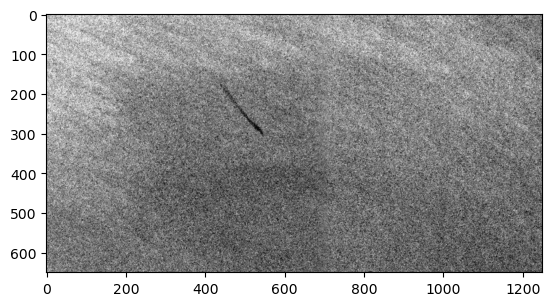

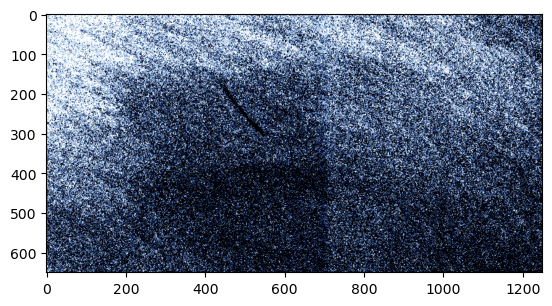

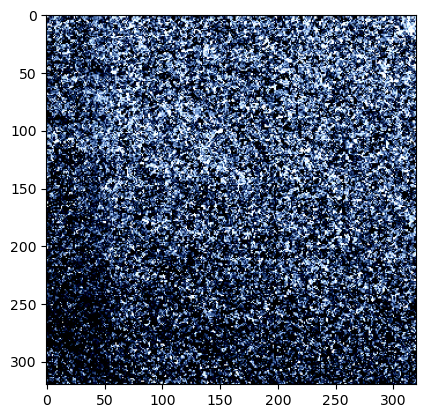

<Figure size 640x480 with 0 Axes>

In [3]:
#Machine learning model for bachelor project
#https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
#https://towardsdatascience.com/u-nets-with-resnet-encoders-and-cross-connections-d8ba94125a2c

from torch.utils.data import Dataset
import torchvision.transforms.v2 as v2
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
import random
import torchvision.transforms.functional as F
import numbers
import torch.nn as nn
from typing import Sequence, Tuple, List, Optional
from torch import Tensor
from torchvision.transforms import _functional_pil as F_pil, _functional_tensor as F_t
from files import config
from PIL import Image, ImageOps
import warnings
import math
from segmentation_models_pytorch.encoders import get_preprocessing_fn

##############################################################
#This part is adapted from the their respective torch classes and functions to be able to handle random transforms using seeds.
def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)
    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)
    return size

def get_dimensions(img: Tensor) -> List[int]:
    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        if isinstance(img, torch.Tensor):
            return F_t.get_dimensions(img)

    return F_pil.get_dimensions(img)

class myRandomApply(torch.nn.Module):
    def __init__(self, transforms, seed, p=0.5):
        super().__init__()
        self.transforms = transforms
        self.p = p
        self.seed = seed

    def forward(self, img):
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        if self.p < torch.rand(1):
            return img
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self) -> str:
        format_string = self.__class__.__name__ + "("
        format_string += f"\n    p={self.p}"
        for t in self.transforms:
            format_string += "\n"
            format_string += f"    {t}"
        format_string += "\n)"
        return format_string

class myRandomHorizontalFlip(torch.nn.Module):
    def __init__(self, seed, p=0.5):
        super().__init__()
        self.p = p
        self.seed = seed

    def forward(self, img):
        if torch.rand(1) < self.p:
            return F.hflip(img)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

class myRandomVerticalFlip(torch.nn.Module):
    def __init__(self, seed, p=0.5):
        super().__init__()
        self.p = p
        self.seed = seed

    def forward(self, img):
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        if torch.rand(1) < self.p:
            return F.vflip(img)
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"
    
class myRandomCrop(torch.nn.Module):

    @staticmethod
    def get_params(img: Tensor, output_size: Tuple[int, int]) -> Tuple[int, int, int, int]:
        _, h, w = F.get_dimensions(img)
        th, tw = output_size

        if h < th or w < tw:
            raise ValueError(f"Required crop size {(th, tw)} is larger than input image size {(h, w)}")

        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, h - th + 1, size=(1,)).item()
        j = torch.randint(0, w - tw + 1, size=(1,)).item()
        return i, j, th, tw

    def __init__(self, size, seed, padding=None, pad_if_needed=False, fill=0, padding_mode="constant"):
        super().__init__()
        self.seed = seed

        self.size = tuple(_setup_size(size, error_msg="Please provide only two dimensions (h, w) for size."))

        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    def forward(self, img):
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        if self.padding is not None:
            img = F.pad(img, self.padding, self.fill, self.padding_mode)

        _, height, width = F.get_dimensions(img)
        # pad the width if needed
        if self.pad_if_needed and width < self.size[1]:
            padding = [self.size[1] - width, 0]
            img = F.pad(img, padding, self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and height < self.size[0]:
            padding = [0, self.size[0] - height]
            img = F.pad(img, padding, self.fill, self.padding_mode)

        i, j, h, w = self.get_params(img, self.size)
        

        return F.crop(img, i, j, h, w)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(size={self.size}, padding={self.padding})"

class MyRandomResizedCrop(torch.nn.Module):
    def __init__(
        self,
        size,
        seed,
        scale=(0.08, 1.0),
        ratio=(3.0 / 4.0, 4.0 / 3.0),
        interpolation=transforms.InterpolationMode.BILINEAR,
        antialias: Optional[bool] = True,
    ):
        super().__init__()
        self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")
        self.seed = seed
        if not isinstance(scale, Sequence):
            raise TypeError("Scale should be a sequence")
        if not isinstance(ratio, Sequence):
            raise TypeError("Ratio should be a sequence")
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("Scale and ratio should be of kind (min, max)")

        if isinstance(interpolation, int):
            interpolation = F._interpolation_modes_from_int(interpolation)

        self.interpolation = interpolation
        self.antialias = antialias
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img: Tensor, scale: List[float], ratio: List[float]) -> Tuple[int, int, int, int]:
        _, height, width = F.get_dimensions(img)
        area = height * width

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i = torch.randint(0, height - h + 1, size=(1,)).item()
                j = torch.randint(0, width - w + 1, size=(1,)).item()
                return i, j, h, w

        # Fallback to central crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w

    def forward(self, img):
        torch.manual_seed(self.seed)
        random.seed(self.seed)
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        return F.resized_crop(img, i, j, h, w, self.size, self.interpolation, antialias=self.antialias)

    def __repr__(self) -> str:
        interpolate_str = self.interpolation.value
        format_string = self.__class__.__name__ + f"(size={self.size}"
        format_string += f", scale={tuple(round(s, 4) for s in self.scale)}"
        format_string += f", ratio={tuple(round(r, 4) for r in self.ratio)}"
        format_string += f", interpolation={interpolate_str}"
        format_string += f", antialias={self.antialias})"
        return format_string
###############################################################

# Custom transform class for resizing images

class isLabel(torch.nn.Module):
    def __call__(self, img):
        if type(img) == torch.Tensor:
            # Resize images using bilinear interpolation
            resim = transforms.Resize(size=tuple(np.int16(np.ceil(random.uniform(0.5, 1.5) * np.array([650, 1250])))))(img)
        else:
            # Resize labels using nearest neighbor interpolation
            resim = transforms.Resize(size=tuple(np.int16(np.ceil(random.uniform(0.5, 1.5) * np.array([650, 1250])))),
                                    interpolation=transforms.InterpolationMode.NEAREST_EXACT)(img)
        return resim
"""class isLabel(torch.nn.Module):
    def __call__(self, img):
        size = tuple(np.int16(np.ceil(random.uniform(0.5, 1.5) * np.array([650, 1250]))))
        if type(img) == torch.Tensor:
            # Resize images using bilinear interpolation
            resim = v2.RandomResize(min_size=size[0], max_size=size[1])(img)
        else:
            # Resize labels using nearest neighbor interpolation
            resim = v2.RandomResize(min_size=size[0], max_size=size[1],
                                    interpolation=transforms.InterpolationMode.NEAREST_EXACT)(img)
        return resim"""


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, lossvalue=None):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.lossvalue = lossvalue

    def early_stop(self, validation_loss):
        if self.lossvalue is not None:
            if validation_loss <= self.lossvalue:
                return True
            return False
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


preprocess_input = get_preprocessing_fn('mobilenet_v2', pretrained='imagenet')

# Read and convert the image to RGB
image = cv2.imread(os.path.join(config.dbg_train_image, "img_0001.jpg"))*1/255
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = Image.open(os.path.join(config.dbg_train_label, "img_0001.png"))
#label = ImageOps.grayscale(label)

# Convert image to tensor and set its type to float
plt.imshow(image)
plt.figure()
image = transforms.ToTensor()(image).type(torch.float)
print(image)
image = preprocess_input(image.cpu().numpy().transpose(1,2,0))
plt.imshow(image)
plt.figure()
image = torch.from_numpy(image.transpose(2,0,1)).type(torch.FloatTensor)


# Generate a random seed for data augmentation
seed = np.random.randint(2147483647)

# Define transformation pipeline

transform = transforms.Compose([
    myRandomApply([isLabel()], seed=seed, p=0.5),
    myRandomHorizontalFlip(seed=seed, p=0.5),
    myRandomVerticalFlip(seed=seed, p=0.5),
    myRandomCrop(seed=seed, size=config.patch_size[0])
])

image = transform(image)
label = transform(label)

print(image)
plt.imshow(image.cpu().numpy().transpose(1,2,0))
plt.figure()
# Squeeze the label tensor and set its type to int64
label = torch.squeeze(transforms.PILToTensor()(label)).type(torch.LongTensor)




In [52]:
#https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import cv2
from PIL import Image
torch.cuda.empty_cache()
file_path = "C:/Users/Mr. Oliver/Desktop/CNN/FinalModels/DeepLabV3/output/unet_oil.pth"
# Load pre-trained DeepLabV3Plus with MobileNetV2 backbone
pretrained_model = torch.load(file_path).to('cuda')


# Read and convert the image to RGB
image = cv2.imread(os.path.join(config.dbg_train_image, "img_0020.jpg"))*1/255
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = Image.open(os.path.join(config.dbg_train_label, "img_002.png"))

label = torch.squeeze(transforms.PILToTensor()(label)).type(torch.LongTensor)
image = transforms.ToTensor()(image).type(torch.FloatTensor)
image = torch.unsqueeze(image, dim=0)
print(image.size())

# Calculate the amount of padding needed
target_height = ((image.size(2) + 15) // 16) * 16
target_width = ((image.size(3) + 15) // 16) * 16
padding_height = target_height - image.size(2)
padding_width = target_width - image.size(3)

print(padding_height)

# Apply zero-padding
padded_image = F.pad(image, (0, padding_width, 0, padding_height))
padded_label = F.pad(label, (0, padding_width, 0, padding_height))
"""
print("Padded image size:", padded_image.size())
pretrained_model = pretrained_model.to('cuda')

# Freeze pre-trained encoder (backbone) layers
for param in pretrained_model.encoder.parameters():
    #print(param.type())
    param.requires_grad = False

# Remove upsampling layer from the decoder
#pretrained_model.decoder.up.scale_factor = 1.0

# Modify the output convolution in the segmentation head
pretrained_model.segmentation_head[0] = nn.Conv2d(256, 5, kernel_size=(1, 1), stride=(1, 1)).to("cuda")

# Optional: Modify the input convolution to accept larger input size
pretrained_model.encoder.features[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False).to("cuda")
"""
pred = pretrained_model(padded_image.to('cuda'))
#print(pretrained_model)
torch.cuda.empty_cache()



torch.Size([1, 3, 650, 1250])
6


torch.Size([650, 1250]) torch.Size([1, 5, 650, 1250]) torch.Size([1, 3, 650, 1250])


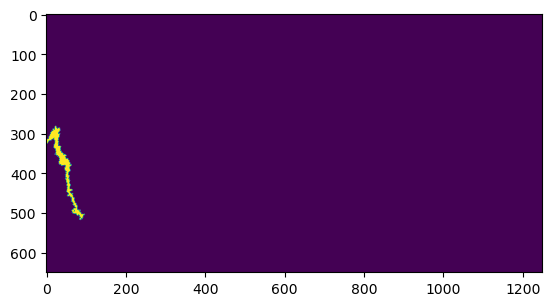

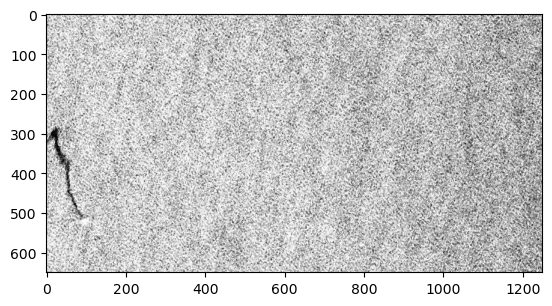

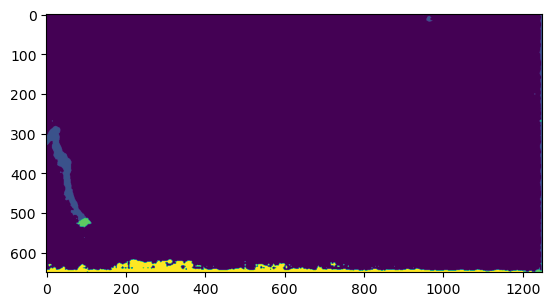

In [54]:
import matplotlib.pyplot as plt

image = padded_image[:, :, :650, :1250]
label = padded_label[:650, :1250]
pred = pred[:, :, :650, :1250]

print(label.size(), pred.size(), image.size())
plt.imshow(label.cpu().numpy())
plt.figure()
plt.imshow(torch.squeeze(image,dim=0).cpu().numpy().transpose(1,2,0))
plt.figure()
plt.imshow(torch.argmax(pred[0], dim=0).detach().cpu().numpy())

In [63]:
image = Image.open(os.path.join(config.dbg_train_image, "img_0020.jpg"))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = Image.open(os.path.join(config.dbg_train_label, "img_0020.png"))
#label = ImageOps.grayscale(label)

# Convert image to tensor and set its type to float
image = transforms.ToTensor()(image).type(torch.float)
print(image.size())
x = torch.rand([12,3,650,1250])
print(x.size())

# Calculate the amount of padding needed
target_height = ((x.size(2) + 31) // 32) * 32
target_width = ((x.size(3) + 31) // 32) * 32
padding_height = target_height - x.size(2)
padding_width = target_width - x.size(3)

# Apply zero-padding
padded_image = F.pad(x, (0, padding_width, 0, padding_height))

print(padded_image.size())

image = torch.squeeze(padded_image, dim=0)
print(image.to(config.device).size())

torch.Size([3, 650, 1250])
torch.Size([12, 3, 650, 1250])
torch.Size([12, 3, 672, 1280])
torch.Size([12, 3, 672, 1280])
